Implementation on new data with Bubble

In [7]:
import re
import sys
import csv
import time
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from featurize_category import tokenize_all
from tqdm import tqdm_notebook
from unidecode import unidecode

from collections import defaultdict
from collections import Counter
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectPercentile
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import recall_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict
from sklearn.cross_validation import LeaveOneLabelOut
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
source = '/Users/elise/Documents/?/? data/new/product_nuts_with_usage_and_product_id.csv'
#source = 'data/product_nuts_with_usage_and_product_id.csv'

In [9]:
data_pn_usage = []

with open(source) as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in tqdm_notebook(readCSV):
        data_pn_usage.append(eval(row[0]))

** Select only those product nuts that have a category ** 

In [12]:
pn_categories = [x for x in data_pn_usage if x.get('categories', '') != '']
id_tokens_categories = tokenize_all(pn_categories)

//anaconda/lib/python2.7/site-packages/unidecode/__init__.py:46: RuntimeWarning: Argument <type 'str'> is not an unicode object. Passing an encoded string will likely have unexpected results.
  _warn_if_not_unicode(string)


In [13]:
len(pn_categories)

177520

- Remove doubles
- Include only those nut products if the usage appears in at least 3 products

In [14]:
# removes doubles
known = set()
no_doubles = []

for d in tqdm_notebook(id_tokens_categories):
    tok = ' '.join(d['tokens'])
    if tok in known: 
        continue
    no_doubles.append(d)
    known.add(tok)

In [15]:
# makes a dict where each tuple has one usage and all the product_ids linked to it
k = [{x['usage']: x['product_id']} for x in no_doubles]
dd = defaultdict(list)

for d in tqdm_notebook(k): 
    for key, value in d.iteritems():
        dd[key].append(value)

In [16]:
# checks if a usage is linked to at least 3 products
allowed_usage = []
for x in tqdm_notebook(dd.items()):
    if len(set(x[1])) > 2:
        allowed_usage.append(x[0])
        
set_allowed_usage = set(allowed_usage)

complete = []
for x in tqdm_notebook(no_doubles):
    if x['usage'] in set_allowed_usage:
        complete.append(x)

LABELS

In [17]:
labels = [x['product_id'] for x in complete]

In [18]:
K_fold = int(len(set(labels)) / 6)

one = set(list(set(labels))[:K_fold])
two = set(list(set(labels))[K_fold:(K_fold * 2)])
three = set(list(set(labels))[(2 * K_fold):(K_fold * 3)])
four = set(list(set(labels))[(3 * K_fold):(K_fold * 4)])
five = set(list(set(labels))[(4 * K_fold):(K_fold * 5)])
six = set(list(set(labels))[(5 * K_fold):])

labels_6 = []
for label in tqdm_notebook(labels):
    if label in one:
        labels_6.append(1)
    elif label in two:
        labels_6.append(2)
    elif label in three:
        labels_6.append(3)
    elif label in four:
        labels_6.append(4)
    elif label in five:
        labels_6.append(5)
    elif label in six:
        labels_6.append(6)

X

In [19]:
text_per_item_pn_TRAIN = [' '.join(tokens['tokens']) for tokens in complete if tokens['product_id'] not in six]
text_per_item_pn_VALIDATE = [' '.join(tokens['tokens']) for tokens in complete if tokens['product_id'] in six]

In [20]:
vectorizer = CountVectorizer(min_df=1, binary=True)
X_TRAIN = vectorizer.fit_transform(text_per_item_pn_TRAIN)

In [21]:
vocab = vectorizer.vocabulary_
vectorizer = CountVectorizer(min_df=1, vocabulary=vocab)
X_VALIDATE = vectorizer.fit_transform(text_per_item_pn_VALIDATE)

Y

In [22]:
Y_TRAIN = [x['usage'] for x in complete if x['product_id'] not in six]
Y_VALIDATE = [x['usage'] for x in complete if x['product_id'] in six]

In [23]:
labels_TRAIN = []
for x in enumerate(labels_6):
    if x[1] != 6:
        labels_TRAIN.append(x[1])

In [24]:
print 'X: ', X_VALIDATE.shape, 'Y: ', len(Y_VALIDATE)
print 'X: ', X_TRAIN.shape, 'Y: ',len(Y_TRAIN), 'Labels: ', len(labels_TRAIN)

X:  (12895, 21469) Y:  12895
X:  (66721, 21469) Y:  66721 Labels:  66721


Cross_Validation

In [112]:
cv = LeaveOneLabelOut(labels_TRAIN)

clf = LinearSVC(random_state = 2, verbose = 1)
scores = cross_val_score(clf, X_TRAIN, Y_TRAIN, cv=cv, scoring='accuracy')

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [113]:
print "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)

Accuracy: 0.68 (+/- 0.05)


** Feature Reduction **

In [172]:
def compute_scores(X, Y, labels):
    cv = LeaveOneLabelOut(labels_TRAIN)
    clf = LinearSVC(random_state = 2, verbose = 1, max_iter=200000)
    scores = cross_val_score(clf, X, Y, cv=cv, scoring='accuracy', n_jobs=-1)
    
    return scores

In [127]:
TRAIN = []
percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

for precentage in percentages:
    TRAIN.append([precentage, SelectPercentile(percentile=precentage).fit_transform(X_TRAIN, Y_TRAIN)])

In [173]:
scores = []
for train_x in tqdm_notebook(TRAIN):
    scores.append([train_x[0], compute_scores(train_x[1], Y_TRAIN, labels_TRAIN)])

In [174]:
for score in scores:
    print "Accuracy Linear SVC " + str(score[0]) + ": %0.2f (+/- %0.2f)" % (score[1].mean(), score[1].std() * 2)

Accuracy Linear SVC 10: 0.63 (+/- 0.06)
Accuracy Linear SVC 20: 0.66 (+/- 0.05)
Accuracy Linear SVC 30: 0.67 (+/- 0.05)
Accuracy Linear SVC 40: 0.67 (+/- 0.05)
Accuracy Linear SVC 50: 0.67 (+/- 0.05)
Accuracy Linear SVC 60: 0.67 (+/- 0.05)
Accuracy Linear SVC 70: 0.67 (+/- 0.05)
Accuracy Linear SVC 80: 0.68 (+/- 0.05)
Accuracy Linear SVC 90: 0.68 (+/- 0.05)
Accuracy Linear SVC 100: 0.68 (+/- 0.05)


** Plot **

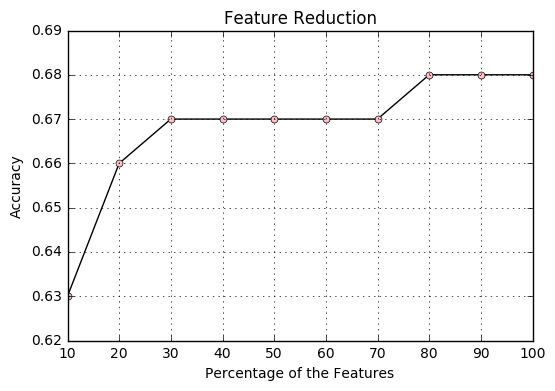

In [5]:
plt.title('Feature Reduction')
plt.xlabel('Percentage of the Features')
plt.ylabel('Accuracy')
plt.grid(True)

x = np.array([score[0] for score in scores])
y = np.array([score[1] for score in scores])

plt.plot(x, y, color='black', marker='o', linestyle='-', markerfacecolor='pink', markersize=5)
plt.savefig('feature_reduction_categories.png')
plt.show()

** Check what is removed **

In [25]:
reduced = SelectPercentile(percentile=2)
reduced.fit(X_TRAIN, Y_TRAIN)
list_of_features = reduced.get_support()

In [26]:
index_removed = []
for x in enumerate(list_of_features):
    if x[1] != True:
        index_removed.append(x[0])

In [27]:
flipped_vocab = {v: k for k, v in vocab.iteritems()}

In [28]:
list_removed = []
for n in index_removed:
    list_removed.append(flipped_vocab[n])

In [29]:
# 99 procent - 1% best
set(vocab.keys()) - set(list_removed)

{u'00',
 u'10l',
 u'2delig',
 u'aanstekers',
 u'aardappelen',
 u'aardappelkroketjes',
 u'aardappelproducten',
 u'aardappelpuree',
 u'aardappelsalade',
 u'aardappelschotel',
 u'abdijkaas',
 u'alcoholvrije',
 u'alcolholvrije',
 u'aloe',
 u'alpro',
 u'always',
 u'amandeldrink',
 u'ambi',
 u'americain',
 u'ananassap',
 u'andijvie',
 u'ansjovisfilets',
 u'antibreakagemask',
 u'appelmoes',
 u'aqua',
 u'aromatisch',
 u'artisjokken',
 u'asperges',
 u'atjar',
 u'augurken',
 u'baba',
 u'baby',
 u'babyverzorging',
 u'babyvoeding',
 u'badkamer',
 u'bagels',
 u'bakbloedworst',
 u'bakleverworst',
 u'bapao',
 u'belegen',
 u'berliner',
 u'beschuit',
 u'bessensap',
 u'bieflappen',
 u'bier',
 u'bieten',
 u'bietensap',
 u'bima',
 u'bitterballen',
 u'blauwaderkaas',
 u'bloemkoolroosjes',
 u'boerenkool',
 u'bolsius',
 u'bonen',
 u'boomstammetje',
 u'bosuitjes',
 u'boterhamworst',
 u'bouillon',
 u'braadsticks',
 u'brie',
 u'bubbels',
 u'bulgaarse',
 u'cacaomassa',
 u'cacaopoeder',
 u'cambozola',
 u'carpacci

In [30]:
print 'suiker' in list_removed
print 'zout' in list_removed

True
True


** Validate **

In [114]:
clf.fit(X_TRAIN, Y_TRAIN)
predictions = clf.predict(X_VALIDATE)

[LibLinear]

In [115]:
def classifaction_report_csv(report):
    report_data = []
    lines = report.encode('ascii', 'ignore').split('\n')
    for line in (lines[2:-3] + [lines[-2]]):
        row = {}
        row_data = line.strip().split('  ')
        row_data = [x for x in row_data if x != '']
        row['class'] = row_data[0]
        row['precision'] = row_data[1]
        row['recall'] = row_data[2]
        row['f1_score'] = row_data[3]
        row['support'] = row_data[4]
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    #dataframe.to_csv('classification_report.csv', index = False)
    return dataframe

report = classification_report(Y_VALIDATE, predictions)
df = classifaction_report_csv(report)

//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [118]:
print 'micro recall score: ',recall_score(Y_VALIDATE, predictions, average = 'micro')

micro recall score:  0.770644335892


- Reliable Recall Macro Score

In [117]:
report_data = []
lines = report.encode('ascii', 'ignore').split('\n')
for line in (lines[2:-3] + [lines[-2]]):
    row = {}
    row_data = line.strip().split('  ')
    row_data = [x for x in row_data if x != '']
    row['class'] = row_data[0]
    row['precision'] = row_data[1]
    row['recall'] = row_data[2]
    row['f1_score'] = row_data[3]
    row['support'] = row_data[4]
    report_data.append(row)
    
recall = []
for d in report_data:
    if d['support'].strip() != '0':
        recall.append(d['recall'])
        
n_recall = [float(x) for x in recall]
print 'macro recall score: ',sum(n_recall) / len(recall)

macro recall score:  0.603302387268
